In [2]:
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer.reparam import TransformReparam, LocScaleReparam
from numpyro.distributions.transforms import AffineTransform
from numpyro.infer import MCMC, NUTS, Predictive, SVI, Trace_ELBO, log_likelihood
from numpyro.infer.autoguide import AutoLaplaceApproximation
import numpyro.optim as optim
from numpyro import handlers
from numpyro.handlers import mask
import jax
from jax.numpy import DeviceArray
import jax.numpy as jnp
from jax import random, lax
from jax import nn as jnn
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '
/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/jax/experimental/stax.py:28: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  warnings.warn('jax.experimental.stax is deprecated, '


In [2]:
d = pd.read_csv('data/tulips.csv', sep=';')
d.sample(5)

,bed,water,shade,blooms
19,c,1,2,47.69
6,a,3,1,224.97
18,c,1,1,10.02
2,a,1,3,111.04
3,a,2,1,183.47


In [3]:
d.describe()

,water,shade,blooms
count,27.00000,27.00000,27.000000
mean,2.00000,2.00000,128.993704
std,0.83205,0.83205,92.683923
min,1.00000,1.00000,0.000000
25%,1.00000,1.00000,71.115000
50%,2.00000,2.00000,111.040000
75%,3.00000,3.00000,190.300000
max,3.00000,3.00000,361.660000


In [4]:
d['W'] = d['water'] - 2
d['S'] = d['shade'] - 2
d['F'] = d['blooms'] / max(d['blooms'])
d['B'] = d['bed'].map({'a':0, 'b':1, 'c':2})

In [5]:
def model(w, s, f=None):

    a = numpyro.sample('a', dist.Normal(0.5,0.25))
    bw = numpyro.sample('bw', dist.Normal(0,0.25))
    bs = numpyro.sample('bs', dist.Normal(0,0.25))
    bws = numpyro.sample('bws', dist.Normal(0,0.25))
    sigma = numpyro.sample('sigma', dist.Exponential(1))

    #mu = a + bw*w + bs*s +bws*w*s
    mu = numpyro.deterministic('mu', a + bw*w + bs*s +bws*w*s)

    blooms = numpyro.sample('blooms', dist.Normal(mu, sigma), obs=f)

m1 = AutoLaplaceApproximation(model)
svi = SVI(model,m1,optim.Adam(1),Trace_ELBO())
svi_result = svi.run(random.PRNGKey(0), 1000, d.W.values, d.S.values, d.F.values)
p1 = svi_result.params

# display summary of quadratic approximation
samples1 = m1.sample_posterior(random.PRNGKey(1), p1, (1000,))
numpyro.diagnostics.print_summary(samples1, group_by_chain=False)

100%|██████████| 1000/1000 [00:00<00:00, 1118.34it/s, init loss: 133.8938, avg. loss [951-1000]: -16.7088]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.36      0.02      0.36      0.32      0.39   1009.20      1.00
        bs     -0.11      0.03     -0.11     -0.16     -0.06    755.46      1.00
        bw      0.21      0.03      0.21      0.16      0.26   1039.19      1.00
       bws     -0.14      0.04     -0.14     -0.20     -0.08   1000.78      1.00
     mu[0]      0.12      0.06      0.12      0.02      0.23    965.48      1.00
     mu[1]      0.15      0.04      0.15      0.09      0.22   1050.03      1.00
     mu[2]      0.18      0.06      0.18      0.09      0.29   1075.66      1.00
     mu[3]      0.47      0.04      0.47      0.39      0.52    659.48      1.00
     mu[4]      0.36      0.02      0.36      0.32      0.39   1009.20      1.00
     mu[5]      0.25      0.04      0.25      0.19      0.31   1052.10      1.00
     mu[6]      0.82      0.06      0.82      0.72      0.93    864.65      1.00
     mu[7]      0.56      0

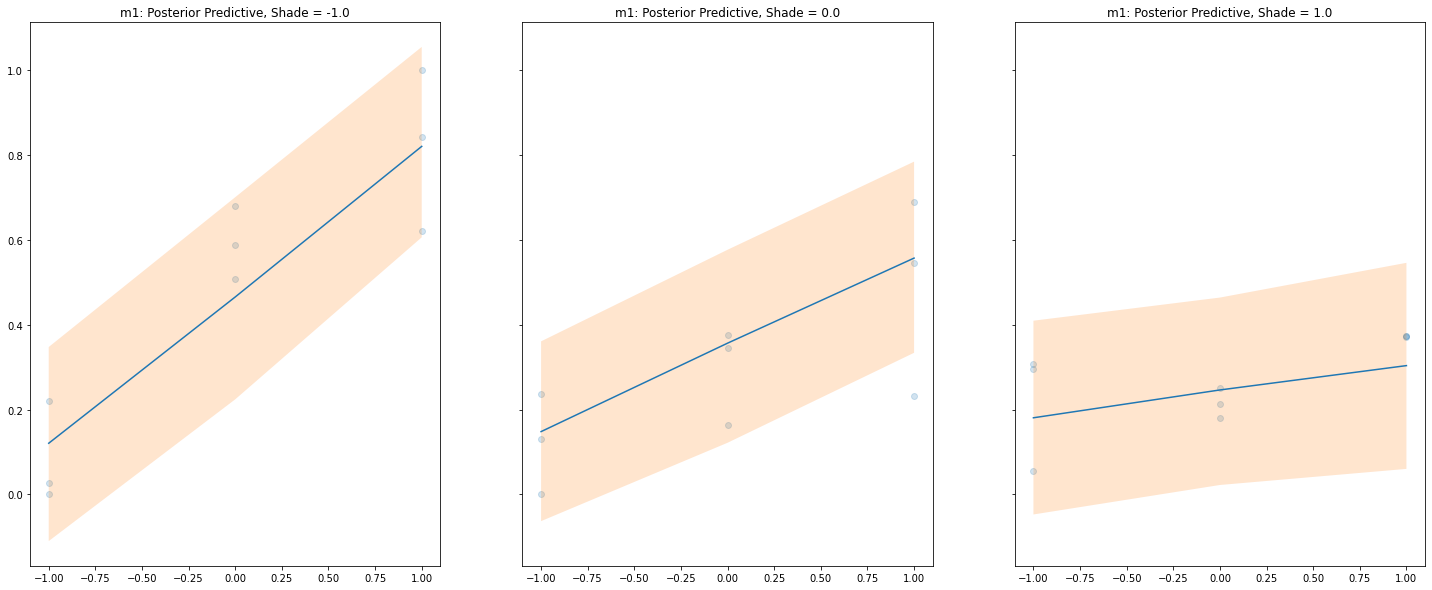

In [6]:
num_charts = 3
num_x_points = 3
water = jnp.linspace(-1, 1, num_x_points)
shade = jnp.linspace(-1, 1, num_charts)
x_water = jnp.tile(water,len(water))
x_shade = jnp.repeat(shade, len(shade))

_predictive = Predictive(model=model, posterior_samples=samples1, guide=m1)
pred = _predictive(random.PRNGKey(2), x_water, x_shade, None)

loc = pred['blooms'].mean(axis=0)
low, high = jnp.percentile(pred['blooms'], jnp.array([5.0, 95.0]), axis=0)

fig, axes = plt.subplots(1, num_charts, sharex=True, sharey=True, figsize=(25,10))
for i in range(num_charts):
    d_filt = d[d['S']==shade[i]]
    idx = i*num_x_points
    axes[i].scatter(d_filt['W'].values, d_filt['F'].values, alpha=0.2)
    axes[i].plot(water, loc[idx:idx+num_x_points])
    axes[i].fill_between(water, low[idx:idx+num_x_points], high[idx:idx+num_x_points], alpha = 0.2)
    axes[i].set_title('m1: Posterior Predictive, Shade = ' + str(shade[i]))

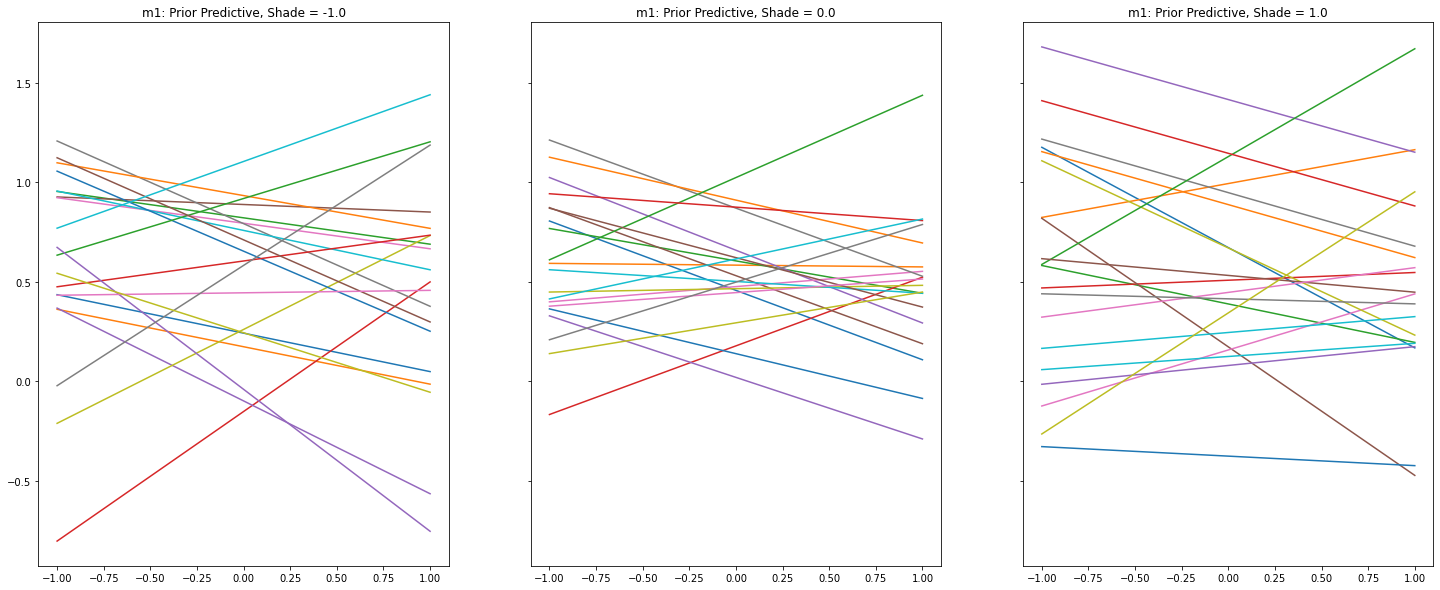

In [7]:
prior_predictive = Predictive(model, num_samples=20, return_sites=['mu'])
prior_pred = prior_predictive(random.PRNGKey(2), x_water, x_shade, None)

fig, axes = plt.subplots(1, num_charts, sharex=True, sharey=True, figsize=(25,10))
for i in range(num_charts):
    idx = i*num_x_points
    for s in range(prior_pred['mu'].shape[0]):
        axes[i].plot(water, prior_pred['mu'][s,idx:idx+num_x_points])
    axes[i].set_title('m1: Prior Predictive, Shade = ' + str(shade[i]))

In [8]:
def model(b, w, s, f=None):

    num_beds = len(set(b))
    a = numpyro.sample('a', dist.Normal(0.5,0.25))
    bw = numpyro.sample('bw', dist.Normal(0,0.25))
    bs = numpyro.sample('bs', dist.Normal(0,0.25))
    bws = numpyro.sample('bws', dist.Normal(0,0.25))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    bb = numpyro.sample('bb', dist.Normal(0,0.5).expand([num_beds,]))

    mu = a + bb[b] + bw*w + bs*s +bws*w*s
    #mu = numpyro.deterministic('mu', a + bb[b] + bw*w + bs*s +bws*w*s)

    blooms = numpyro.sample('blooms', dist.Normal(mu, sigma), obs=f)

m2 = AutoLaplaceApproximation(model)
svi = SVI(model,m2,optim.Adam(1),Trace_ELBO())
svi_result = svi.run(random.PRNGKey(0), 1000, d.B.values, d.W.values, d.S.values, d.F.values)
p2 = svi_result.params

# display summary of quadratic approximation
samples2 = m2.sample_posterior(random.PRNGKey(1), p2, (1000,))
numpyro.diagnostics.print_summary(samples2, group_by_chain=False)

100%|██████████| 1000/1000 [00:00<00:00, 1085.94it/s, init loss: 144.8512, avg. loss [951-1000]: -19.5070]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.44      0.20      0.44      0.09      0.73    870.38      1.00
     bb[0]     -0.17      0.20     -0.17     -0.52      0.15    870.06      1.00
     bb[1]     -0.05      0.20     -0.05     -0.40      0.25    877.66      1.00
     bb[2]     -0.03      0.20     -0.03     -0.40      0.25    882.24      1.00
        bs     -0.11      0.03     -0.12     -0.15     -0.07    909.69      1.00
        bw      0.21      0.03      0.21      0.17      0.25    927.56      1.00
       bws     -0.14      0.03     -0.15     -0.20     -0.09    896.34      1.00
     sigma      0.11      0.02      0.11      0.09      0.14    936.48      1.00



In [9]:
logprob1= log_likelihood(m1.model, samples1, d.W.values, d.S.values, d.F.values)
az1 = az.from_dict({}, log_likelihood={"blooms": logprob1["blooms"][None, ...]})

logprob2= log_likelihood(m2.model, samples2, d.B.values, d.W.values, d.S.values, d.F.values)
az2 = az.from_dict({}, log_likelihood={"blooms": logprob2["blooms"][None, ...]})


In [10]:
compare = az.compare({"m1 Without bed": az1, "m2 Indicator for bed": az2}, ic="waic", scale="deviance")
compare

/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/arviz/stats/stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/arviz/stats/stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m2 Indicator for bed,0,-25.495139,8.610231,0.000000,0.66176,9.040599,0.000000,True,deviance
m1 Without bed,1,-22.644448,6.207797,2.850692,0.33824,9.810991,7.737062,True,deviance


In [4]:
d = pd.read_csv('data/Wines2012.csv', sep=';')

In [5]:
d.sample(5)

,judge,flight,wine,score,wine.amer,judge.amer
170,Francis Schott,red,A2,19.0,0,1
109,Tyler Colman,red,J2,11.0,0,1
88,Francis Schott,white,I1,17.0,1,1
142,Linda Murphy,red,C2,17.0,1,1
59,Linda Murphy,white,J1,17.0,0,1


In [6]:
judge_map = { name:i for i, name in enumerate(d.judge.unique()) }
wine_map = { name:i for i, name in enumerate(d.wine.unique()) }
def reverse(map):
    return { v:k for k,v in map.items() }

In [7]:
scaler = StandardScaler()
d['S'] = scaler.fit_transform(d[['score']])
d['W'] = d['wine'].map(wine_map)
d['J'] = d['judge'].map(judge_map)

<AxesSubplot:>

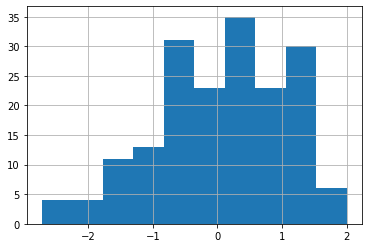

In [8]:
d.S.hist()

In [9]:
def model(w, j, s=None):
    num_wines = len(set(w))
    num_judges = len(set(j))
    a = numpyro.sample('a', dist.Normal(0,0.2))
    bw = numpyro.sample('bw', dist.Normal(0,1).expand([num_wines,]))
    bj = numpyro.sample('bj', dist.Normal(0,1).expand([num_judges,]))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    mu = numpyro.deterministic('mu', a + bw[w] + bj[j])
    score = numpyro.sample('score', dist.Normal(mu,sigma), obs=s)

m1 = AutoLaplaceApproximation(model)
svi = SVI(model,m1,optim.Adam(1),Trace_ELBO())
svi_result = svi.run(random.PRNGKey(0), 1000, d.W.values, d.J.values, d.S.values)
p1 = svi_result.params

# display summary of quadratic approximation
samples1 = m1.sample_posterior(random.PRNGKey(1), p1, (1000,))
numpyro.diagnostics.print_summary(samples1, group_by_chain=False)

100%|██████████| 1000/1000 [00:01<00:00, 536.15it/s, init loss: 7798.3120, avg. loss [951-1000]: 241.4415]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.00      0.19      0.01     -0.33      0.28    929.06      1.00
     bj[0]     -0.60      0.28     -0.59     -1.05     -0.15    957.09      1.00
     bj[1]     -0.38      0.29     -0.38     -0.84      0.12   1025.99      1.00
     bj[2]      0.88      0.28      0.89      0.42      1.32   1067.40      1.00
     bj[3]      0.15      0.29      0.15     -0.30      0.63    969.00      1.00
     bj[4]     -0.73      0.28     -0.73     -1.16     -0.26    939.15      1.00
     bj[5]      0.53      0.28      0.54      0.02      0.93    999.86      1.00
     bj[6]     -0.31      0.28     -0.30     -0.73      0.16   1025.92      1.00
     bj[7]      0.23      0.28      0.24     -0.26      0.66    969.35      1.00
     bj[8]      0.24      0.28      0.24     -0.18      0.70   1060.58      1.00
     bw[0]      0.16      0.31      0.16     -0.39      0.63   1014.28      1.00
     bw[1]      0.28      0

<ErrorbarContainer object of 3 artists>

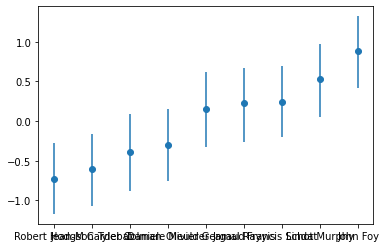

In [10]:
bj =samples1['bj']
loc = bj.mean(axis=0)
low, high = jnp.percentile(bj, jnp.array([5.0, 95.0]), axis=0)
lower_bar = loc-low
upper_bar = high-loc
sort_idx = jnp.argsort(loc)
x = [reverse(judge_map)[i] for i in list(sort_idx)]
y = loc[np.array(sort_idx)]
plt.scatter(x, y)
plt.errorbar(x, y, yerr=[lower_bar[np.array(sort_idx)], upper_bar[np.array(sort_idx)]], ls='none')

<ErrorbarContainer object of 3 artists>

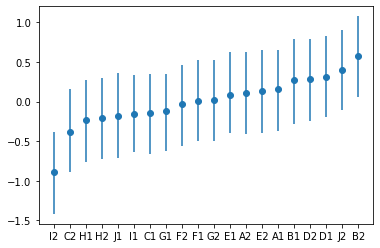

In [11]:
bw =samples1['bw']
loc = bw.mean(axis=0)
low, high = jnp.percentile(bw, jnp.array([5.0, 95.0]), axis=0)
lower_bar = loc-low
upper_bar = high-loc
sort_idx = jnp.argsort(loc)
x = [reverse(wine_map)[i] for i in list(sort_idx)]
y = loc[np.array(sort_idx)]
plt.scatter(x, y)
plt.errorbar(x, y, yerr=[lower_bar[np.array(sort_idx)], upper_bar[np.array(sort_idx)]], ls='none')

In [13]:
d['F'] = d['flight'].map({'red':0, 'white':1})
d['WA'] = d['wine.amer']
d['JA'] = d['judge.amer']
d.sample(5)

,judge,flight,wine,score,wine.amer,judge.amer,S,W,J,F,WA,JA
173,Francis Schott,red,D2,15.0,1,1,0.301143,13,8,0,1,1
161,Jamal Rayyis,red,B2,19.5,0,0,1.995074,11,7,0,0,0
106,Tyler Colman,red,G2,14.0,0,1,-0.075286,16,1,0,0,1
86,Francis Schott,white,G1,15.0,1,1,0.301143,6,8,1,1,1
141,Linda Murphy,red,B2,14.0,0,1,-0.075286,11,5,0,0,1


In [14]:
def model(f, wa, ja, s=None):
    num_flights = len(set(f))
    a = numpyro.sample('a', dist.Normal(0,0.2))
    bf = numpyro.sample('bf', dist.Normal(0,1).expand([num_flights,]))
    bwa = numpyro.sample('bwa', dist.Normal(0,1).expand([2,]))
    bja = numpyro.sample('bja', dist.Normal(0,1).expand([2,]))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    mu = numpyro.deterministic('mu', a + bf[f] + bwa[wa] + bja[ja])
    score = numpyro.sample('score', dist.Normal(mu,sigma), obs=s)

m1 = AutoLaplaceApproximation(model)
svi = SVI(model,m1,optim.Adam(1),Trace_ELBO())
svi_result = svi.run(random.PRNGKey(0), 1000, d.F.values, d.WA.values, d.JA.values, d.S.values)
p1 = svi_result.params

# display summary of quadratic approximation
samples1 = m1.sample_posterior(random.PRNGKey(1), p1, (1000,))
numpyro.diagnostics.print_summary(samples1, group_by_chain=False)


100%|██████████| 1000/1000 [00:01<00:00, 544.52it/s, init loss: 511.7832, avg. loss [951-1000]: 259.0410]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.00      0.20      0.00     -0.36      0.31    870.38      1.00
     bf[0]     -0.03      0.61     -0.03     -1.04      0.94    984.95      1.00
     bf[1]     -0.03      0.62     -0.02     -1.09      0.90   1006.77      1.00
    bja[0]     -0.11      0.59     -0.12     -1.11      0.77   1063.02      1.00
    bja[1]      0.14      0.58      0.13     -0.88      1.01   1061.60      1.00
    bwa[0]      0.10      0.58      0.12     -0.83      1.09    930.43      1.00
    bwa[1]     -0.08      0.58     -0.06     -0.93      0.94    925.49      1.00
     mu[0]     -0.22      0.14     -0.22     -0.44      0.02    928.91      1.00
     mu[1]     -0.22      0.14     -0.22     -0.44      0.02    928.91      1.00
     mu[2]     -0.03      0.16     -0.03     -0.29      0.22    907.65      1.00
     mu[3]     -0.03      0.16     -0.03     -0.29      0.22    907.65      1.00
     mu[4]     -0.22      0

In [15]:
def model(f, wa, ja, s=None):
    num_flights = len(set(f))

    bfwa = numpyro.sample('bfwa', dist.Normal(0,2).expand([num_flights,2]))
    bfja = numpyro.sample('bfja', dist.Normal(0,2).expand([num_flights,2]))
    bwja = numpyro.sample('bwja', dist.Normal(0,2).expand([2,2]))
    sigma = numpyro.sample('sigma', dist.Exponential(1))


    #mu = numpyro.deterministic('mu', bf[f] + bwa[wa] + bja[ja] + bfwa[f,wa] + bfja[f,ja] + bwja[wa,ja] )
    mu = numpyro.deterministic('mu', bfwa[f,wa] + bfja[f,ja] + bwja[wa,ja] )

    score = numpyro.sample('score', dist.Normal(mu,sigma), obs=s)

m1 = AutoLaplaceApproximation(model)
svi = SVI(model,m1,optim.Adam(1),Trace_ELBO())
svi_result = svi.run(random.PRNGKey(0), 1000, d.F.values, d.WA.values, d.JA.values, d.S.values)
p1 = svi_result.params

# display summary of quadratic approximation
samples1 = m1.sample_posterior(random.PRNGKey(1), p1, (1000,))
numpyro.diagnostics.print_summary(samples1, group_by_chain=False)

100%|██████████| 1000/1000 [00:01<00:00, 619.66it/s, init loss: 3900.3308, avg. loss [951-1000]: 271.5150]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
 bfja[0,0]     -0.06      1.28     -0.05     -2.18      1.95    999.84      1.00
 bfja[0,1]      0.15      1.27      0.15     -2.11      2.00    929.68      1.00
 bfja[1,0]     -0.11      1.31     -0.08     -2.10      2.07    908.47      1.00
 bfja[1,1]      0.07      1.27      0.10     -2.02      2.04    859.73      1.00
 bfwa[0,0]      0.24      1.26      0.21     -1.72      2.45   1121.32      1.00
 bfwa[0,1]     -0.19      1.28     -0.19     -2.51      1.68   1108.79      1.00
 bfwa[1,0]     -0.03      1.28     -0.07     -2.08      2.08    915.95      1.00
 bfwa[1,1]      0.12      1.31      0.16     -1.84      2.44   1020.17      1.00
 bwja[0,0]     -0.08      1.26     -0.05     -2.12      1.95    797.50      1.00
 bwja[0,1]      0.05      1.29      0.04     -2.08      2.03    930.84      1.00
 bwja[1,0]     -0.06      1.32     -0.01     -2.39      1.95   1011.92      1.00
 bwja[1,1]     -0.07      1

In [16]:
def model(f, wa, ja, s=None):
    num_flights = len(set(f))

    b = numpyro.sample('b', dist.Normal(0,2).expand([num_flights,2,2]))
    sigma = numpyro.sample('sigma', dist.Exponential(1))

    mu = numpyro.deterministic('mu', b[f,wa,ja] )

    score = numpyro.sample('score', dist.Normal(mu,sigma), obs=s)

m1 = AutoLaplaceApproximation(model)
svi = SVI(model,m1,optim.Adam(1),Trace_ELBO())
svi_result = svi.run(random.PRNGKey(0), 1000, d.F.values, d.WA.values, d.JA.values, d.S.values)
p1 = svi_result.params

# display summary of quadratic approximation
samples1 = m1.sample_posterior(random.PRNGKey(1), p1, (1000,))
numpyro.diagnostics.print_summary(samples1, group_by_chain=False)

100%|██████████| 1000/1000 [00:01<00:00, 832.68it/s, init loss: 510.9691, avg. loss [951-1000]: 263.9435]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  b[0,0,0]      0.24      0.24      0.25     -0.13      0.67   1004.86      1.00
  b[0,0,1]      0.32      0.21      0.32     -0.05      0.63    875.37      1.00
  b[0,1,0]     -0.41      0.20     -0.41     -0.73     -0.09   1182.05      1.00
  b[0,1,1]     -0.02      0.18     -0.02     -0.31      0.27   1002.56      1.00
  b[1,0,0]     -0.38      0.25     -0.38     -0.79      0.03    901.37      1.00
  b[1,0,1]      0.20      0.22      0.20     -0.15      0.58    809.30      1.00
  b[1,1,0]      0.04      0.20      0.04     -0.27      0.34   1082.29      1.00
  b[1,1,1]      0.05      0.18      0.05     -0.23      0.35   1110.21      1.00
     mu[0]      0.04      0.20      0.04     -0.27      0.34   1082.29      1.00
     mu[1]      0.04      0.20      0.04     -0.27      0.34   1082.29      1.00
     mu[2]     -0.38      0.25     -0.38     -0.79      0.03    901.37      1.00
     mu[3]     -0.38      0

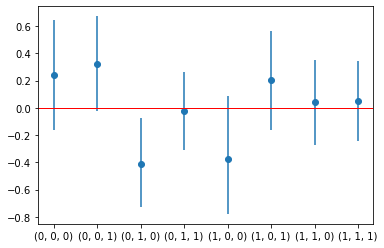

In [17]:
b = samples1['b'].reshape(1000,-1)
loc = b.mean(axis=0)
low, high = jnp.percentile(b, jnp.array([5.0, 95.0]), axis=0)
lower_bar = loc-low
upper_bar = high-loc
x = [ str(index) for index in np.ndindex(samples1['b'].shape[1:]) ]
y = loc
plt.scatter(x, y)
plt.errorbar(x, y, yerr=[lower_bar, upper_bar], ls='none')
plt.axhline(linewidth=1, color='r')

[0.20105623 0.2181613  0.22467002 0.24273539 0.24273539 0.24574436
 0.27779576 0.3082601  0.31567812 0.36691242]


(array([17.8745794 ,  4.12490294,  1.83329001,  1.37496722,  0.45832269,
         0.61109667,  0.61109667,  0.15277417,  0.30554833,  0.15277417]),
 array([0.00326748, 0.03963197, 0.07599647, 0.11236096, 0.14872546,
        0.18508995, 0.22145444, 0.25781894, 0.29418343, 0.33054793,
        0.36691242], dtype=float32),
 <BarContainer object of 10 artists>)

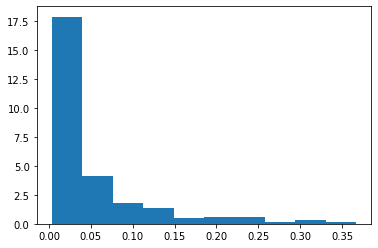

In [35]:
# check for influential points using WAIC pintwise penalty, which is the variance of the logprobs across the posterier samples for each y datapoint
logprob = log_likelihood(m1.model, samples1, d.F.values, d.WA.values, d.JA.values, d.S.values)["score"]
penalty = logprob.var(axis=0).sort()
print(penalty[-10:])
plt.hist(penalty, density=True)
